In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np 
import math

import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
c = np.load('calib.npy', allow_pickle=True).item()

In [3]:
c

{'K0': array([[1.09058826e+03, 0.00000000e+00, 4.22000000e+02],
        [0.00000000e+00, 1.09058826e+03, 3.38000000e+02],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 'd0': array([-0.03720395, -0.2353958 ,  0.        ,  0.        ,  0.        ]),
 'K1': array([[1.09454675e+03, 0.00000000e+00, 4.22000000e+02],
        [0.00000000e+00, 1.09454675e+03, 3.38000000e+02],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 'd1': array([-0.04744541, -0.00026868,  0.        ,  0.        ,  0.        ]),
 'R': array([[ 0.91398722, -0.07814026,  0.39814758],
        [ 0.07619891,  0.99687725,  0.02072451],
        [-0.39852369,  0.01139647,  0.91708726]]),
 't': array([[-407.240143 ],
        [  -1.5053668],
        [  85.688652 ]])}

# Exercise 13.2

In [5]:
im0 = cv2.imread("sequence/frames0_0.png")
size = (im0.shape[1], im0.shape[0])
stereo = cv2.stereoRectify(c['K0'], c['d0'], c['K1'],
c['d1'], size, c['R'], c['t'], flags=0)
R0, R1, P0, P1 = stereo[:4]
maps0 = cv2.initUndistortRectifyMap(c['K0'], c['d0'], R0, P0, size, cv2.CV_32FC2)
maps1 = cv2.initUndistortRectifyMap(c['K1'], c['d1'], R1, P1, size, cv2.CV_32FC2)

In [6]:
i = 0
im = cv2.imread("sequence/frames0_%d.png"%i)

In [7]:
img = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY).astype('float32')

In [8]:
ims = cv2.remap(img, *maps0, cv2.INTER_LINEAR)

In [9]:
ims0 = []
for i in range(26):
    im = cv2.imread("sequence/frames0_%d.png"%i)
    img = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY).astype('float32')
    ims = cv2.remap(img, *maps0, cv2.INTER_LINEAR)
    ims0.append(ims)
    

In [10]:
ims1 = []
for i in range(26):
    im = cv2.imread("sequence/frames1_%d.png"%i)
    img = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY).astype('float32')
    ims = cv2.remap(img, *maps1, cv2.INTER_LINEAR)
    ims1.append(ims)

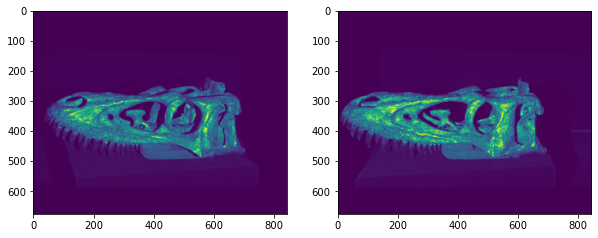

In [11]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(ims0[0])
plt.subplot(1,2,2)
plt.imshow(ims1[0])

# Exercise 13.3

In [13]:
primary0 = ims0[2:18]

In [14]:
fft_primary0 = np.fft.rfft(primary0,axis = 0)

In [15]:
theta_primary0 = np.angle(fft_primary0[1])

In [16]:
secondary0 = ims0[18:26]

In [17]:
fft_secondary0 = np.fft.rfft(secondary0,axis = 0)
theta_secondary0 = np.angle(fft_secondary0[1])

In [18]:
theta_c0 = (theta_primary0 - theta_secondary0) % (2 * np.pi)

In [20]:
o_primary0 = np.rint((40*theta_c0-theta_primary0)/(2*np.pi))

In [21]:
theta0 = ((2 * np.pi * o_primary0 + theta_primary0) / 40) % (2 * np.pi)

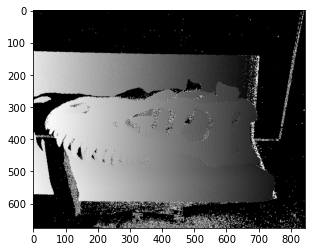

In [22]:
plt.imshow(theta0,'gray')

In [23]:
def unwrap(ims):
    primary = ims[2:18]
    fft_primary = np.fft.rfft(primary,axis = 0)
    theta_primary = np.angle(fft_primary[1])
    secondary = ims[18:26]
    fft_secondary = np.fft.rfft(secondary,axis = 0)
    theta_secondary = np.angle(fft_secondary[1])
    theta_c = (theta_primary - theta_secondary) % (2 * np.pi)
    o_primary = np.rint((40*theta_c-theta_primary)/(2*np.pi))
    theta = ((2 * np.pi * o_primary + theta_primary) / 40) % (2 * np.pi)
    
    return theta

In [24]:
theta0 = unwrap(ims0)
theta1 = unwrap(ims1)

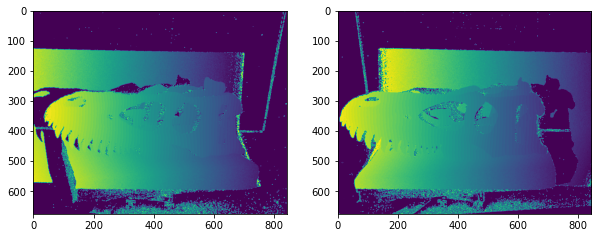

In [25]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(theta0)
plt.subplot(1,2,2)
plt.imshow(theta1)

# Exercise 13.4

In [26]:
mask0 = (ims0[0] - ims0[1]) > 15 # Camera 0
mask1 = (ims1[0] - ims1[1]) > 15 # Camera 1

theta0_masked = theta0.copy()
theta1_masked = theta1.copy()


theta0_masked[~mask0] = 0 
theta1_masked[~mask1] = 0

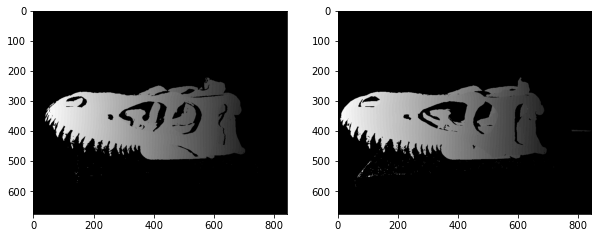

In [27]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(theta0_masked,'gray')
plt.subplot(1,2,2)
plt.imshow(theta1_masked,'gray')

In [28]:
theta1_masked.max()

6.245246858970608

# Exercise 13.5

In [29]:
qs0 =[]
qs1 = []
row, column = theta0_masked.shape


In [30]:
disparity = np.zeros((row,column))
for i in range(row):
    for j0 in range(column):
        if mask0[i,j0]:
            minthetadiff = 255
            for j1 in range(column):
                thetadiff = theta0_masked[i,j0]-theta1_masked[i,j1]
                if np.abs(thetadiff)<minthetadiff:
                    minthetadiff = np.abs(thetadiff)
                    disparity[i,j0] =j0-j1
                    jmatch = j1
                    
            if mask1[i,jmatch]:
                qs0.append([j0,i])
                qs1.append([jmatch,i])

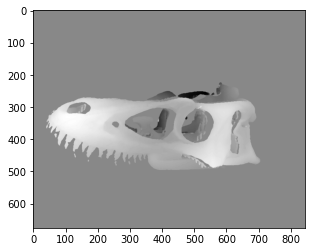

In [31]:
plt.imshow(cv2.medianBlur(disparity.astype(np.float32), 5),'gray')

In [32]:
matches0 = np.array(qs0, dtype=np.float32).T
matches1 = np.array(qs1, dtype=np.float32).T
matches0.shape, matches1.shape

((2, 111756), (2, 111756))

In [33]:
Qh = cv2.triangulatePoints(P0,P1,matches0,matches1)
Qih = Qh[:-1]/Qh[-1]

In [ ]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(Qih.T)
o3d.visualization.draw_geometries([pcd])